# Code for Section 6: 0-1 Loss Plots

These experiments use the same models as those in Section 6.

## Trees on MNIST
**NOTE: PART A OF Section_5_C_Trees_Varying_Depth.ipynb MUST BE EXECUTED FIRST IN ORDER FOR THIS CODE TO WORK**




In [1]:
"""
Imports and setting parameters
"""
import matplotlib.pyplot as plt
%matplotlib inline

import time
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from decompose.data_utils import load_standard_dataset, load_data
from decompose.experiments import load_results
import logging
from decompose import ZeroOneLoss, CrossEntropy
from matplotlib.ticker import MaxNLocator
import numpy as np

from tqdm import tqdm
from functools import partial
import matplotlib
import os

if not os.path.exists("images"):
    os.mkdir("images")
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("decomposition_objects"):
    os.mkdir("decomposition_objects")


plt.rcParams.update({
    "text.usetex": True})

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)


DATASET_NAME = "mnist"
train_data, train_labels, test_data, test_labels = load_data(DATASET_NAME)
N_TRIALS = 100
PARAMETER_NAME = "n_estimators"
PARAMETER_VALUES = range(1, 21, 1)

models = ["Bagging (max depth 5)",
          "Bagging (unconstrained)",
          "Random Forest"]


In [2]:

"""
Load results objects from Section_5_Trees_mnist.ipynb
"""
# Load results objects from experiment
results_objects = {}
for name in models:
    results_objects[name] = load_results(f"data/Fig4_{name}_{DATASET_NAME}_results_{N_TRIALS}_v2.pkl")


bag_results = results_objects["Bagging (unconstrained)"]
rf_results = results_objects["Random Forest"]
print(bag_results.decomposition_prefix)


# Set up functions (with no arguments) to retrieve decomposition_objects from results
decomposition_objects = [partial(bag_results.get_decomposition_object, idx, 0) for idx in range(len(rf_results.parameter_values))]
decomposition_objects += [partial(rf_results.get_decomposition_object, idx, 0) for idx in range(len(rf_results.parameter_values))]

print("objects loaded")


decomposition_objects/Bagging (unconstrained)_v2
objects loaded


# Figures 17: Error and Bias-Variance-Diversity Effects

In [3]:
"""
Create zero one decomposition objects and collect statistics
"""
bias_effects = np.zeros(len(decomposition_objects))
variance_effects = np.zeros(len(decomposition_objects))
diversity_effects = np.zeros(len(decomposition_objects))
ensemble_risks = np.zeros(len(decomposition_objects))
expected_risks = np.zeros(len(decomposition_objects))

    
for decomp_idx, decomp in enumerate(tqdm(decomposition_objects)):
    decomp = decomp()
    pred = decomp.pred
    labels = decomp.labels

    # Zero-one loss expects numberical class labels, Cross-Entropy gives one hot vectors
    # So we need to convert one to the other
    predicted_class = np.argmax(decomp.pred, axis=3)
    zero_one_decomp = ZeroOneLoss(predicted_class, labels)
    diversity_effects[decomp_idx] = zero_one_decomp.diversity_effect.mean()
    bias_effects[decomp_idx] = zero_one_decomp.average_bias.mean()
    variance_effects[decomp_idx] = zero_one_decomp.average_variance_effect.mean()
    expected_risks[decomp_idx] = zero_one_decomp.expected_ensemble_loss.mean()
    
    

100%|██████████| 40/40 [03:16<00:00,  4.92s/it]


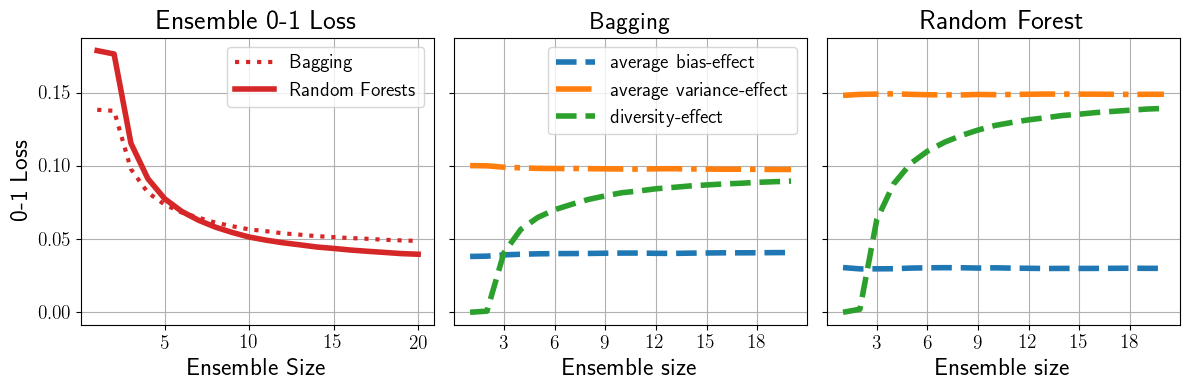

In [4]:
"""
Plot 0-1 Loss and bias-variance diversity curves
"""

fig, axes = plt.subplots(ncols=3, figsize=(12,4), sharey=True)


line_colors = ['tab:red', 'tab:red',  'tab:red', 'y']
line_styles = ['-', ":", "-", '-']
axes[0].plot(np.arange(20) + 1, expected_risks[:20], label="Bagging", lw=3, color=line_colors[1], ls=line_styles[1])
axes[0].plot(np.arange(20) + 1, expected_risks[20:], label="Random Forests", lw=4, color=line_colors[2], ls=line_styles[2])
axes[0].set_xlabel("Ensemble Size", size=18)
axes[0].set_ylabel("0-1 Loss", size=18)
axes[0].set_title("Ensemble 0-1 Loss", size=20)
axes[0].legend(prop={"size":14})
axes[0].grid()

axes[1].set_title("Bagging", size=18)
axes[1].plot(np.arange(20) + 1, bias_effects[:20], label="average bias-effect", linewidth=4, linestyle="--")
axes[1].plot(np.arange(20) + 1, variance_effects[:20], label="average variance-effect", linewidth=4, linestyle="-.")
axes[1].plot(np.arange(20) + 1, diversity_effects[:20], label="diversity-effect", linewidth=4, linestyle="--")
#ax.plot(ensemble_risk[:20], label="ensemble risk", linewidth=4, linestyle=":")

axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

axes[1].set_xlabel("Ensemble size", size=18)
axes[1].grid()


axes[2].set_title("Random Forest", size=20)
axes[2].plot(np.arange(20) + 1, bias_effects[20:], label="average bias-effect", linewidth=4, linestyle="--")
axes[2].plot(np.arange(20) + 1, variance_effects[20:], label="average variance-effect", linewidth=4, linestyle="-.")
axes[2].plot(np.arange(20) + 1, diversity_effects[20:], label="diversity-effect", linewidth=4, linestyle="--")
#ax.plot(ensemble_risk[:20], label="ensemble risk", linewidth=4, linestyle=":")
axes[2].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[2].set_xlabel("Ensemble size", size=18)
axes[1].legend(prop={'size': 14})
axes[2].grid()

plt.tight_layout()
plt.savefig("images/zo_diversity_effect_plots_w_errors.pdf", bbox_inches="tight")
plt.show()




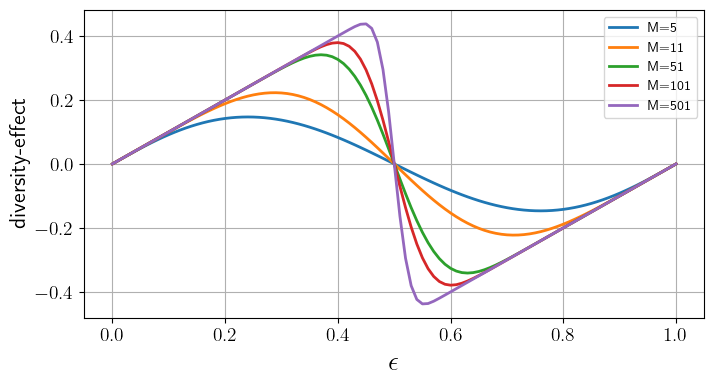

In [3]:
"""
Plot for binary classification theory section
"""
from scipy.special import comb

def majority_vote_error(M, epsilon):
    error = 0
    for k in range(np.ceil((M-1)/2).astype(int) + 1, M + 1 ):
        error += epsilon ** k * (1 - epsilon) ** (M-k) * comb(M, k)
    return error

def diversity_effect_epsilon(M, epsilon):
    return epsilon - majority_vote_error(M, epsilon)

fig, ax = plt.subplots(figsize=(8,4))
for M in [5, 11, 51, 101, 501]:
    epsilons = np.arange(0, 1.01, 0.01)
    ensemble_errors = np.zeros_like(epsilons)
    diversity_effects = np.zeros_like(epsilons)
    for idx, epsilon in enumerate(epsilons):
        diversity_effects[idx] = diversity_effect_epsilon(M, epsilon)
    plt.plot(epsilons, diversity_effects, label=f"M={M}", lw=2)


plt.xlabel("$\epsilon$", size=20)
plt.ylabel("diversity-effect", size=16)
plt.legend()
plt.grid()
plt.savefig("images/diversity_epsilon.pdf", bbox_inches="tight")
plt.show()


(100, 20, 5000)
(5000,)
0.0044
0.03


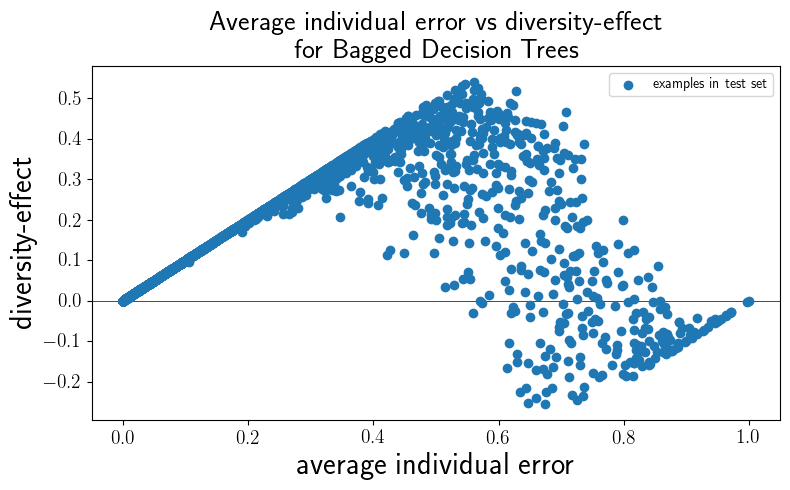

In [5]:
"""
Scatter plot for diversity-effect vs average individual error
"""
fig, ax = plt.subplots(figsize=(8, 5))
ax.axhline(y=0., color='black', linewidth=0.5, linestyle='-', zorder=0)

decomp = decomposition_objects[19]()
pred = decomp.pred
labels = decomp.labels

predicted_class = np.argmax(decomp.pred, axis=3)
zero_one_decomp = ZeroOneLoss(predicted_class, labels)
print(zero_one_decomp.pred.shape)
print(labels.shape)
models_correct = (zero_one_decomp.pred == labels).mean(axis=(0,1))
# plt.scatter(zero_one_decomp.diversity_effect, 1 - corrects.mean(axis=(0, 1)), c=1- models_correct, cmap=cmap)
plt.scatter(1- models_correct, zero_one_decomp.diversity_effect, c="tab:blue", label="examples in test set")
plt.ylabel("diversity-effect", size=22) 
print((models_correct < 0.1).mean())
print((zero_one_decomp.diversity_effect < 0).mean())
#plt.ylabel("Probability $\overline{f}(\mathbf{x}; D)$ is correct", size=16)
plt.xlabel("average individual error", size=22)
plt.title("Average individual error vs diversity-effect \nfor Bagged Decision Trees", size=20)
plt.legend()


COLOR = "black"
TEXT_COLOR = "black"
X_OFFSET = 0.05
Y_OFFSET = 0.055
SIZE = 20
BG_COLOR = "#ffffffd0"



# save figure with decision trees
plt.tight_layout()
plt.savefig("images/zo_negative_diversity_scatter_reversed_monochrome.pdf")

plt.show()


# Boosting Experiments

The rest of this notebook runs and analyses results of experiments used to generate Figure 18 in https://arxiv.org/abs/2301.03962v1. We train three different kinds of ensembles: A Bagging ensemble, and AdaBoost ensemble and a LogitBoost ensemble.

## Bagging Baselines


In [ ]:
import sys
sys.path.append("../models/")


from decompose import data_utils, BVDExperiment
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import os

if not os.path.exists("decomposition_objects"):
    os.mkdir("decomposition_objects")
if not os.path.exists("data"):
    os.mkdir("data")

from adaboost import AdaBoost, LogitBoost, AdaBoostModelWrapper

N_TRIALS = 2000
N_ESTIMATORS = 200
datasets = [ "mease"]
FRAC_TRAIN = 200
MAX_LEAF = 2

for dataset in datasets:
    np.random.seed(0)
    DECOMPOSITIONS_FILE_PREFIX = f"decomposition_objects/bagging_vary_n_leaf_{MAX_LEAF}_trials_{N_TRIALS}_ens_{N_ESTIMATORS}_boosting_comparison_{FRAC_TRAIN}"
    np.random.seed(0)
    train_X, train_y, test_X, test_y = data_utils.load_standard_dataset(dataset,
                                                                        frac_training=FRAC_TRAIN,
                                                                        normalize_data=True,
                                                                        label_noise=0.
                                                                        )

    bagging_ens = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes=MAX_LEAF),
                                n_estimators=N_ESTIMATORS, warm_start=False)

    classification_experiment = BVDExperiment(bagging_ens, bootstrap=False,
                                              n_samples=.9, ensemble_warm_start=False, loss="cross_entropy",
                                              save_decompositions=True, decompositions_prefix=DECOMPOSITIONS_FILE_PREFIX + "_" + dataset,
                                              trials_progress_bar=True)

    logging.debug(f"Starting experiment on {bagging_ens}\nMax leaf nodes: {MAX_LEAF}\nn_estimators: {N_ESTIMATORS}")
    classification_experiment.run_experiment(train_X, train_y, test_X, test_y, n_trials=N_TRIALS)

    classification_experiment.results_object.save_results(f"data/bagging_varying_estimators_{dataset}_results_{N_TRIALS}_leaf_{MAX_LEAF}_ens_{N_ESTIMATORS}_fractrain_{FRAC_TRAIN}_boosting_comparison.pkl")

## AdaBoost

In [ ]:

datasets = ["mease"]
N_TRIALS = 2000
N_ESTIMATORS = 200
SHRINKAGE = 1.
MAX_LEAF = 2
FRAC_TRAIN = 200


DECOMPOSITIONS_FILE_PREFIX = f"decomposition_objects/adaboost_vary_n_leaf_{MAX_LEAF}_trials_{N_TRIALS}_ens_{N_ESTIMATORS}_shrink_{SHRINKAGE}_fractrain_{FRAC_TRAIN}"
for dataset in datasets:
    np.random.seed(0)
    train_X, train_y, test_X, test_y = data_utils.load_standard_dataset(dataset,
                                                                        frac_training=FRAC_TRAIN,
                                                                        normalize_data=True,
                                                                        label_noise=0.
                                                                        )

    adaboost_ens = AdaBoost(DecisionTreeClassifier(max_leaf_nodes=MAX_LEAF),
                                n_estimators=N_ESTIMATORS,
                                shrinkage=SHRINKAGE)

    classification_experiment = BVDExperiment(adaboost_ens, bootstrap=False,
                                              n_samples=.9, ensemble_warm_start=False, loss="exponential",
                                              save_decompositions=True, decompositions_prefix=DECOMPOSITIONS_FILE_PREFIX + "_" + dataset,
                                              trials_progress_bar=True)

    logging.debug(f"Starting experiment on {adaboost_ens}\nMax leaf nodes: {MAX_LEAF}\nn_estimators: {N_ESTIMATORS}\nshrinkage:{SHRINKAGE}\nfrac_train:{FRAC_TRAIN}")
    classification_experiment.run_experiment(train_X,
                                             train_y,
                                             test_X,
                                             test_y,
                                             n_trials=N_TRIALS)

    if SHRINKAGE != 1.:
        classification_experiment.results_object.save_results(f"data/adaboost_varying_estimators_{dataset}_results_{N_TRIALS}_leaf_{MAX_LEAF}_ens_{N_ESTIMATORS}_shrink_{SHRINKAGE}_fractrain_{FRAC_TRAIN}.pkl")
    else:
        classification_experiment.results_object.save_results(f"data/adaboost_varying_estimators_{dataset}_results_{N_TRIALS}_leaf_{MAX_LEAF}_ens_{N_ESTIMATORS}_fractrain_{FRAC_TRAIN}.pkl")

## LogitBoost

In [ ]:
N_TRIALS = 2000
N_ESTIMATORS = 200
datasets = [ "mease"]
SHRINKAGE = 1.
FRAC_TRAIN = 200
MAX_LEAF = 2


for dataset in datasets:
    DECOMPOSITIONS_FILE_PREFIX = f"decomposition_objects/logitboost_vary_n_leaf_{MAX_LEAF}_trials_{N_TRIALS}_ens_{N_ESTIMATORS}_shrink_{SHRINKAGE}_fractrain_{FRAC_TRAIN}"
    np.random.seed(0)
    train_X, train_y, test_X, test_y = data_utils.load_standard_dataset(dataset,
                                                                        frac_training=FRAC_TRAIN,
                                                                        normalize_data=True,
                                                                        label_noise=0.
                                                                        )

    logitboost_ens = LogitBoost(DecisionTreeRegressor(max_leaf_nodes=MAX_LEAF),
                                n_estimators=N_ESTIMATORS, warm_start=True,
                                shrinkage=SHRINKAGE)

    classification_experiment = BVDExperiment(logitboost_ens, bootstrap=False,
                                              n_samples=.9, ensemble_warm_start=False, loss="logistic",
                                              save_decompositions=True, decompositions_prefix=DECOMPOSITIONS_FILE_PREFIX + "_" + dataset,
                                              trials_progress_bar=True)

    logging.debug(f"Starting experiment on {logitboost_ens}\nMax leaf nodes: {MAX_LEAF}\nn_estimators: {N_ESTIMATORS}\nshrinkage:{SHRINKAGE}\nfrac_train:{FRAC_TRAIN}")
    classification_experiment.run_experiment(train_X, train_y, test_X, test_y,
                                                                     n_trials=N_TRIALS)

    if SHRINKAGE != 1.:
        classification_experiment.results_object.save_results(f"data/logitboost_varying_estimators_{dataset}_results_{N_TRIALS}_leaf_{MAX_LEAF}_ens_{N_ESTIMATORS}_shrink_{SHRINKAGE}_fractrain_{FRAC_TRAIN}.pkl")
    else:
        classification_experiment.results_object.save_results(f"data/logitboost_varying_estimators_{dataset}_results_{N_TRIALS}_leaf_{MAX_LEAF}_ens_{N_ESTIMATORS}_fractrain_{FRAC_TRAIN}.pkl")

## Generate Figure for Boosting

In [17]:
"""
Take the decomposition for the margin loss/cross entropy and convert it into a (weighted) zero-one loss
"""
from decompose.experiments import load_results
from decompose import ZeroOneLoss
from tqdm import tqdm
from decompose.zero_one_loss import mode_with_random_ties
import pickle

N_TRIALS = 2000
N_ESTIMATORS = 200
FRAC_TRAIN = 200
datasets = ["mease"]

configs = [{"model": "adaboost", "MAX_LEAF": 2, "SHRINKAGE": 1.},
           {"model": "bagging", "MAX_LEAF": 2},
           {"model": "logitboost", "MAX_LEAF": 2, "SHRINKAGE": 1.}
            ]

for config in configs:
    print(config)
    MAX_LEAF = config["MAX_LEAF"]
    if "SHRINKAGE" in config:
        SHRINKAGE = config["SHRINKAGE"]
    else:
        SHRINKAGE = 1. 
    model = config["model"]
    
    for dataset in datasets:
        if model == "bagging":
            results_name = f"data/bagging_varying_estimators_{dataset}_results_{N_TRIALS}_leaf_{MAX_LEAF}_ens_{N_ESTIMATORS}_fractrain_{FRAC_TRAIN}_boosting_comparison.pkl"
        elif model == "rf":
            results_name = f"data/rf_varying_estimators_{dataset}_results_{N_TRIALS}_ens_{N_ESTIMATORS}_fractrain_{FRAC_TRAIN}_boosting_comparison.pkl"
        else:
            if SHRINKAGE != 1.:
                results_name = f"data/{model}_varying_estimators_{dataset}_results_{N_TRIALS}_leaf_{MAX_LEAF}_ens_{N_ESTIMATORS}_shrink_{SHRINKAGE}_fractrain_{FRAC_TRAIN}.pkl"
            else:
                results_name = f"data/{model}_varying_estimators_{dataset}_results_{N_TRIALS}_leaf_{MAX_LEAF}_ens_{N_ESTIMATORS}_fractrain_{FRAC_TRAIN}.pkl"
        results = load_results(results_name)
        full_decomp = results.get_decomposition_object(0, 0)

        n_estimators_list = np.array(np.arange(1, N_ESTIMATORS+1, 10))
        n_estimators_list = np.append(n_estimators_list, N_ESTIMATORS)

        
        if model in ["bagging", "rf"]:
            full_pred = np.argmax(full_decomp.pred, axis=3)
        else:
            full_pred = (full_decomp.pred > 0) * 1
            full_weights = np.abs(full_decomp.pred)
        labels = (full_decomp.labels == 1) * 1

        bias_effects = np.zeros(len(n_estimators_list))
        variance_effects = np.zeros(len(n_estimators_list))
        diversity_effects = np.zeros(len(n_estimators_list))
        ensemble_errors = np.zeros(len(n_estimators_list))

        ensemble_bias_effects = np.zeros(len(n_estimators_list))
        ensemble_variance_effects = np.zeros(len(n_estimators_list))

        for est_idx, n_estimators in enumerate(tqdm(n_estimators_list)):
            
            abridged_preds = full_pred[:, :n_estimators, ...]
            
            if model in  ["logitboost", "adaboost"]:
                abridged_weights =  full_weights[:, :n_estimators, ...]
                ensemble_preds = mode_with_random_ties(abridged_preds, weights=abridged_weights, axis=1, random_ties=True)
                zo_decomp = ZeroOneLoss(abridged_preds, labels, weights=abridged_weights, random_ties=True)
            else:
                ensemble_preds = mode_with_random_ties(abridged_preds, weights=None, axis=1, random_ties=True)
                zo_decomp = ZeroOneLoss(abridged_preds, labels, weights=None, random_ties=True)
            no_weights_decomp = ZeroOneLoss(ensemble_preds, labels, weights=None)


            bias_effects[est_idx] = zo_decomp.average_bias.mean()
            variance_effects[est_idx] = zo_decomp.average_variance_effect.mean()
            diversity_effects[est_idx] = zo_decomp.diversity_effect.mean()
            ensemble_errors[est_idx] = zo_decomp.expected_ensemble_loss.mean()
            ensemble_bias_effects[est_idx] = no_weights_decomp.ensemble_bias.mean()
            ensemble_variance_effects[est_idx] = no_weights_decomp.ensemble_variance_effect.mean()

        
        results = {"bias_effects": bias_effects,
                   "variance_effects": variance_effects,
                   "diversity_effects": diversity_effects,
                   "ensemble_errors": ensemble_errors,
                   "ensemble_bias_effects": ensemble_bias_effects,
                   "ensemble_variance_effects": ensemble_variance_effects}
        
        if model in ["adaboost", "logitboost"]:
            results_f_name = f"data/{model}_figure_data_{dataset}_{N_TRIALS}_{N_ESTIMATORS}_{FRAC_TRAIN}_{MAX_LEAF}_{SHRINKAGE}.pkl"
        if model == "bagging":
            results_f_name = f"data/{model}_figure_data_{dataset}_{N_TRIALS}_{N_ESTIMATORS}_{FRAC_TRAIN}_{MAX_LEAF}.pkl"
        if model == "rf":
            results_f_name = f"data/{model}_figure_data_{dataset}_{N_TRIALS}_{N_ESTIMATORS}_{FRAC_TRAIN}.pkl"
        print(results_f_name)
        with open(results_f_name, "wb+") as f:
            pickle.dump(results, f)




{'model': 'adaboost', 'MAX_LEAF': 2, 'SHRINKAGE': 1.0}


100%|██████████| 21/21 [04:24<00:00, 12.60s/it]


data/adaboost_figure_data_mease_2000_200_200_2_1.0.pkl
{'model': 'bagging', 'MAX_LEAF': 2}


100%|██████████| 21/21 [03:29<00:00,  9.96s/it]


data/bagging_figure_data_mease_2000_200_200_2.pkl
{'model': 'logitboost', 'MAX_LEAF': 2, 'SHRINKAGE': 1.0}


100%|██████████| 21/21 [04:23<00:00, 12.53s/it]

data/logitboost_figure_data_mease_2000_200_200_2_1.0.pkl



Bagging
bias: 0.308
variance: 0.10126279500000002
diversity: 0.07897679500000002
error: 0.330286

AdaBoost
bias: 0.2741955383528127
variance: 0.18154447898730888
diversity: 0.20695301734012053
error: 0.248787

LogitBoost
bias: 0.2549828690414657
variance: 0.17969617182973405
diversity: 0.1878610408712005
error: 0.24681799999999998


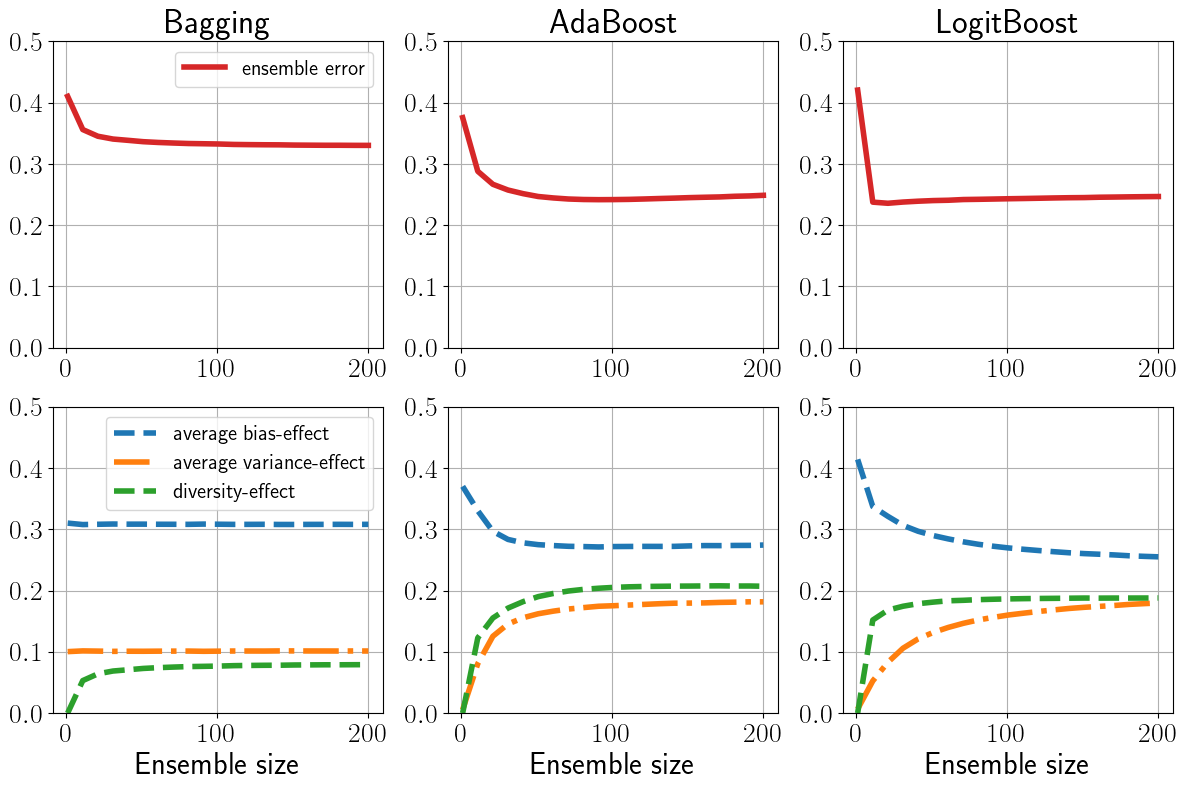

In [25]:
import pickle

"""
Generate figure
"""

def plot_lines(results_name, n_estimators_list, ax, show_error=True, show_bvd_components=True, title=None, show_x_label=True,
               print_stats=False):

    # NOTE: you have to set the dataset in the configs above

    upper_ylims = [0.5, 0.5, 0.5, 0.5]

    with open(results_name, "rb") as f:
        results = pickle.load(f)

    be = results["bias_effects"]  
    ve = results["variance_effects"]
    de = results["diversity_effects"]
    ee = results["ensemble_errors"]
    
    if print_stats:
        print(f"bias: {be[-1]}")
        print(f"variance: {ve[-1]}")
        print(f"diversity: {de[-1]}")
        print(f"error: {ee[-1]}")

    if show_bvd_components:
        ax.plot(n_estimators_list, be, label="average bias-effect", linewidth=4, linestyle="--")
        ax.plot(n_estimators_list, ve, label="average variance-effect", linewidth=4, linestyle="-.")
        ax.plot(n_estimators_list, de, label="diversity-effect", linewidth=4, linestyle="--")
    if show_error:
        ax.plot(n_estimators_list, ee, label="ensemble error", linewidth=4, linestyle="-", color="tab:red")
    
    #ax.plot(n_estimators_list, de + ee, label="average error", linewidth=4, linestyle="-")

    #ax[idx].plot(ensemble_risk[:20], label="ensemble risk", linewidth=4, linestyle=":")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    ax.set_ylim(bottom=0, top=0.5)
    if show_x_label:
        ax.set_xlabel("Ensemble size", size=22)
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.grid()
    ax.set_title(title, size=24)


dataset = "mease"
N_TRIALS = 2000
N_ESTIMATORS = 200
FRAC_TRAIN = 200
n_estimators_list = np.array(np.arange(1, N_ESTIMATORS+1, 10))
n_estimators_list = np.concatenate((n_estimators_list, np.array([N_ESTIMATORS])))

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))



file_name = f"data/bagging_figure_data_{dataset}_{N_TRIALS}_{N_ESTIMATORS}_{FRAC_TRAIN}_2.pkl"
print("\nBagging")
plot_lines(file_name,
           n_estimators_list,
           axes[0, 0], 
           title="Bagging",
           show_x_label=False,
           show_error=True,
           show_bvd_components=False,
           print_stats=True)

plot_lines(file_name,
           n_estimators_list,
           axes[1, 0], 
           title=None,
           show_x_label=True,
           show_error=False,
           show_bvd_components=True)


file_name = f"data/adaboost_figure_data_{dataset}_{N_TRIALS}_{N_ESTIMATORS}_{FRAC_TRAIN}_2_1.0.pkl"
print("\nAdaBoost")
plot_lines(file_name, 
           n_estimators_list, 
           axes[0, 1], 
           title="AdaBoost", 
           show_x_label=False, 
           show_bvd_components=False,
           print_stats=True,
           show_error=True)
plot_lines(file_name, 
           n_estimators_list, 
           axes[1, 1], 
           title=None, 
           show_x_label=True, 
           show_bvd_components=True,
           show_error=False)


file_name = f"data/logitboost_figure_data_{dataset}_{N_TRIALS}_{N_ESTIMATORS}_{FRAC_TRAIN}_2_1.0.pkl"
print("\nLogitBoost")
plot_lines(file_name, 
           n_estimators_list, 
           axes[0, 2], 
           title="LogitBoost", 
           show_x_label=False, 
           show_bvd_components=False,
           print_stats=True,
           show_error=True)
plot_lines(file_name, 
           n_estimators_list, 
           axes[1, 2], 
           title=None, 
           show_x_label=True, 
           show_bvd_components=True,
           show_error=False)


axes[0, 0].legend(prop={"size":15})
axes[1, 0].legend(prop={"size":15})

plt.tight_layout()
plt.savefig("images/adaboost_bagging_comparison.pdf")
plt.show()

